# Linear Regression
Here we use the Linear Regression method on the converted data from the descriptive_analysis.ipynb.

https://www.ritchieng.com/machine-learning-evaluate-linear-regression-model/

In [226]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn import utils
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.linear_model import LassoCV
np.random.seed(1)

In [227]:
test = pd.read_csv('./data/converted_test_2020_07_13_17-11-30.csv', index_col=0)
train = pd.read_csv('./data/converted_train_2020_07_13_17-11-30.csv', index_col=0)

In [228]:
# Check for nulls
print(train.isnull().values.any())
print(test.isnull().values.any())

False
False


In [229]:
trainFeatures = [['min_future_price_in_eur', 'Duration_Time', 'price_in_eur']]
for feature in trainFeatures:
    train[feature] = np.log1p(train[feature])

    
testFeatures = [['Duration_Time', 'price_in_eur']]
for feature in testFeatures:
    test[feature] = np.log1p(test[feature])
train

,Request_Date,Flight_Date,Duration_Time,Departure_hour,flight_unique_id,route_abb,flight_number,Price,Currency,min_future_price,price_in_eur,min_future_price_in_eur,Request_Weekday,Request_timeofday,Departure_timeofday,flight_distance_km,Request_hour,Request_Date_Month,Flight_Date_Month
0,2019-06-03 11:00:00,2019-06-05 19:00:00,4.043051,19:00,2019-06-05 FR 146,SXF-STN,FR 146,208.07,€,259.07,5.342669,5.560951,Monday,Morning,Evening,907.2,11:00,6,6
1,2019-06-03 23:00:00,2019-06-05 19:00:00,3.806662,19:00,2019-06-05 FR 146,SXF-STN,FR 146,259.07,€,259.07,5.560951,5.560951,Monday,Night,Evening,907.2,23:00,6,6
2,2019-06-04 11:00:00,2019-06-05 19:00:00,3.496508,19:00,2019-06-05 FR 146,SXF-STN,FR 146,259.07,€,259.07,5.560951,5.560951,Tuesday,Morning,Evening,907.2,11:00,6,6
3,2019-06-04 23:00:00,2019-06-05 19:00:00,3.044522,19:00,2019-06-05 FR 146,SXF-STN,FR 146,259.07,€,259.07,5.560951,5.560951,Tuesday,Night,Evening,907.2,23:00,6,6
4,2019-06-03 11:00:00,2019-06-05 21:00:00,4.077537,21:00,2019-06-05 FR 147,STN-SXF,FR 147,127.49,£,223.37,4.736015,5.293034,Monday,Morning,Night,907.2,11:00,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83619,2019-08-01 11:00:00,2019-09-10 10:00:00,6.866933,10:00,2019-09-10 FR 8543,SXF-STN,FR 8543,35.69,€,39.69,3.602504,3.705982,Thursday,Morning,Morning,907.2,11:00,8,9
83620,2019-08-01 23:00:00,2019-09-10 10:00:00,6.854355,10:00,2019-09-10 FR 8543,SXF-STN,FR 8543,46.83,€,39.69,3.867653,3.705982,Thursday,Night,Morning,907.2,23:00,8,9
83621,2019-08-02 11:00:00,2019-09-10 10:00:00,6.841615,10:00,2019-09-10 FR 8543,SXF-STN,FR 8543,46.83,€,39.69,3.867653,3.705982,Friday,Morning,Morning,907.2,11:00,8,9
83622,2019-08-02 23:00:00,2019-09-10 10:00:00,6.828712,10:00,2019-09-10 FR 8543,SXF-STN,FR 8543,39.69,€,39.69,3.705982,3.705982,Friday,Night,Morning,907.2,23:00,8,9


In [230]:
# One Hot encoding for categorical values / Drop first category is a must for linear regression
train = pd.get_dummies(train, columns=['Request_Weekday', 'Request_timeofday', 'Departure_timeofday', 'flight_number', 'Request_hour', 'Departure_hour'], drop_first=True)
test = pd.get_dummies(test, columns=['Request_Weekday', 'Request_timeofday', 'Departure_timeofday', 'flight_number', 'Request_hour', 'Departure_hour'], drop_first=True)

In [231]:
# Add train column
test['train'] = 0
train['train'] = 1

# Equal columns across both tables
combined = pd.concat([train,test], sort=False)
train = combined[combined['train'] == 1]
test = combined[combined['train'] == 0]

# Fill NaN with 0
train = train.fillna(0)
test = test.fillna(0)

# Drop train column
test.drop(['train'], axis=1, inplace=True)
train.drop(['train'], axis=1, inplace=True)
test

,Request_Date,Flight_Date,Duration_Time,flight_unique_id,route_abb,Price,Currency,min_future_price,price_in_eur,min_future_price_in_eur,...,flight_number_FR 8545,Request_hour_23:00,Departure_hour_18:00,Departure_hour_19:00,Departure_hour_21:00,Departure_hour_22:00,Departure_hour_6:00,Departure_hour_7:00,Departure_hour_8:00,Departure_hour_9:00
0,2019-06-03 11:00:00,2019-07-02 07:00:00,6.541030,2019-07-02 FR 145,STN-SXF,26.87,£,0.0,3.211314,0.0,...,0,0,0,0,0,0,0,1,0,0.0
1,2019-06-03 23:00:00,2019-07-02 07:00:00,6.523562,2019-07-02 FR 145,STN-SXF,39.46,£,0.0,3.582648,0.0,...,0,1,0,0,0,0,0,1,0,0.0
2,2019-06-04 11:00:00,2019-07-02 07:00:00,6.505784,2019-07-02 FR 145,STN-SXF,39.46,£,0.0,3.583964,0.0,...,0,0,0,0,0,0,0,1,0,0.0
3,2019-06-04 23:00:00,2019-07-02 07:00:00,6.487684,2019-07-02 FR 145,STN-SXF,39.46,£,0.0,3.583964,0.0,...,0,1,0,0,0,0,0,1,0,0.0
4,2019-06-05 11:00:00,2019-07-02 07:00:00,6.469250,2019-07-02 FR 145,STN-SXF,39.46,£,0.0,3.582791,0.0,...,0,0,0,0,0,0,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5578,2019-07-30 23:00:00,2019-08-02 22:00:00,4.276666,2019-08-02 FR 8545,SXF-STN,42.83,€,0.0,3.780319,0.0,...,1,1,0,0,0,1,0,0,0,0.0
5579,2019-07-31 11:00:00,2019-08-02 22:00:00,4.094345,2019-08-02 FR 8545,SXF-STN,50.99,€,0.0,3.951051,0.0,...,1,0,0,0,0,1,0,0,0,0.0
5580,2019-07-31 23:00:00,2019-08-02 22:00:00,3.871201,2019-08-02 FR 8545,SXF-STN,50.99,€,0.0,3.951051,0.0,...,1,1,0,0,0,1,0,0,0,0.0
5581,2019-08-01 11:00:00,2019-08-02 22:00:00,3.583519,2019-08-02 FR 8545,SXF-STN,50.99,€,0.0,3.951051,0.0,...,1,0,0,0,0,1,0,0,0,0.0


In [232]:
# Drop columns we do not need from train
train_dropped = train.drop(columns=['route_abb', 'min_future_price', 'Currency', 'flight_unique_id', 'Price', 'flight_distance_km', 'Request_Date', 'Flight_Date', 'Request_Date_Month', 'Flight_Date_Month'])

# Drop columns we do not need from test
test_dropped = test.drop(columns=['route_abb', 'min_future_price', 'Currency', 'flight_unique_id', 'Price', 'flight_distance_km', 'min_future_price', 'min_future_price_in_eur', 'Request_Date', 'Flight_Date', 'Request_Date_Month', 'Flight_Date_Month'])

In [233]:
# Generate test and target / Figure out which features to drop. 'min_future_price_in_eur' needs to be dropped!
X = train_dropped.drop(columns=['min_future_price_in_eur'])
y = train_dropped['min_future_price_in_eur'].values

In [234]:
test_dropped

,Duration_Time,price_in_eur,Request_Weekday_Monday,Request_Weekday_Saturday,Request_Weekday_Sunday,Request_Weekday_Thursday,Request_Weekday_Tuesday,Request_Weekday_Wednesday,Request_timeofday_Night,Departure_timeofday_Morning,...,flight_number_FR 8545,Request_hour_23:00,Departure_hour_18:00,Departure_hour_19:00,Departure_hour_21:00,Departure_hour_22:00,Departure_hour_6:00,Departure_hour_7:00,Departure_hour_8:00,Departure_hour_9:00
0,6.541030,3.211314,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0.0
1,6.523562,3.582648,1,0,0,0,0,0,1,1,...,0,1,0,0,0,0,0,1,0,0.0
2,6.505784,3.583964,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0.0
3,6.487684,3.583964,0,0,0,0,1,0,1,1,...,0,1,0,0,0,0,0,1,0,0.0
4,6.469250,3.582791,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5578,4.276666,3.780319,0,0,0,0,1,0,1,0,...,1,1,0,0,0,1,0,0,0,0.0
5579,4.094345,3.951051,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0.0
5580,3.871201,3.951051,0,0,0,0,0,1,1,0,...,1,1,0,0,0,1,0,0,0,0.0
5581,3.583519,3.951051,0,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0.0


# Feature importance / Not used as RSME not lower

In [248]:
# Features with the highest absolute coef_ value are considered the most important
feature_names = X.columns
clf = LassoCV(cv=100).fit(X, y)
print(clf.score(X, y))
importance = np.abs(clf.coef_)
print(importance)

0.8646046865385951
[1.71599817e-01 8.25210796e-01 2.52062326e-02 0.00000000e+00
 2.36632885e-02 0.00000000e+00 1.36567211e-02 1.14246105e-02
 4.62925965e-03 0.00000000e+00 1.72003015e-02 4.41528106e-03
 0.00000000e+00 3.65483443e-02 6.83617903e-02 0.00000000e+00
 7.75692234e-03 2.14750076e-02 4.48330909e-03 4.63789176e-02
 1.11585963e-02 0.00000000e+00 8.84715753e-05 9.65690111e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.60522123e-02
 8.01175222e-03 0.00000000e+00 0.00000000e+00]


In [249]:
idx_third = importance.argsort()[-3]
threshold = importance[idx_third] + 0.01

idx_features = (-importance).argsort()[:2]
name_features = np.array(feature_names)[idx_features]
print('Selected features: {}'.format(name_features))

sfm = SelectFromModel(clf, threshold=threshold)
sfm.fit(X, y)
X_transform = sfm.transform(X)

n_features = sfm.transform(X).shape[1]

Selected features: ['price_in_eur' 'Duration_Time']


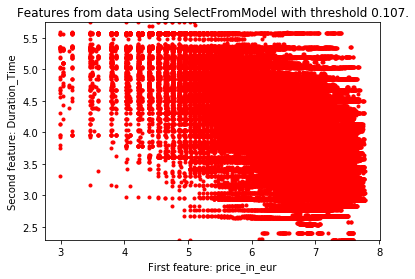

In [250]:
plt.title(
    "Features from data using SelectFromModel with "
    "threshold %0.3f." % sfm.threshold)
feature1 = X_transform[:, 0]
feature2 = X_transform[:, 1]
plt.plot(feature1, feature2, 'r.')
plt.xlabel("First feature: {}".format(name_features[0]))
plt.ylabel("Second feature: {}".format(name_features[1]))
plt.ylim([np.min(feature2), np.max(feature2)])
plt.show()

# Build model

In [238]:
# Split dataset into train and test data (might want to try random_state=0 to randomize each calculation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((66899, 31), (66899,), (16725, 31), (16725,))

In [239]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_model = lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

In [240]:
print('coefficients')
print(lin_reg.intercept_)
list(zip(X.columns, lin_reg.coef_))
# For a given amount of price_in_eur,  ad spending, an increase of $1000 in TV ad spending is associated with an increase in Sales of 45.765 widgets.

coefficients
1.6232099678050718


[('Duration_Time', -0.1737514524161395),
 ('price_in_eur', 0.8237888300363585),
 ('Request_Weekday_Monday', -0.03974027921718147),
 ('Request_Weekday_Saturday', -0.012896565899289327),
 ('Request_Weekday_Sunday', -0.03838546415726059),
 ('Request_Weekday_Thursday', -0.010090453306462691),
 ('Request_Weekday_Tuesday', -0.029564493275645577),
 ('Request_Weekday_Wednesday', -0.02799020849310724),
 ('Request_timeofday_Night', -0.0027359418054731964),
 ('Departure_timeofday_Morning', -0.014186696668498078),
 ('Departure_timeofday_Night', -0.04614136859892942),
 ('flight_number_FR 145', 0.021443489745159406),
 ('flight_number_FR 146', -0.02421827112481256),
 ('flight_number_FR 147', 0.07526468547099142),
 ('flight_number_FR 1546', -0.11261739296477491),
 ('flight_number_FR 1547', 0.0264848814043069),
 ('flight_number_FR 1686', -0.007455259123241979),
 ('flight_number_FR 1687', -0.02764255564275157),
 ('flight_number_FR 8542', 0.01754513033567804),
 ('flight_number_FR 8543', 0.046069450640110

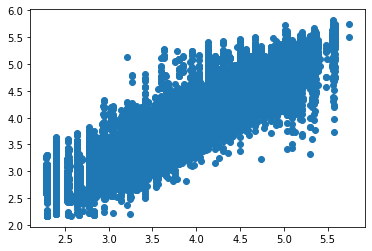

In [241]:
# Make cross validated predictions
predictions = cross_val_predict(lin_model, X, y, cv=6)
plt.scatter(y, predictions)

In [242]:
df_pred = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df_pred

,Actual,Predicted
0,4.079738,4.115367
1,5.184421,5.387578
2,2.840990,2.662770
3,5.093099,5.137300
4,3.753502,3.908941
...,...,...
16720,3.044046,2.935224
16721,4.805438,4.627058
16722,3.204777,2.952736
16723,3.791887,3.324866


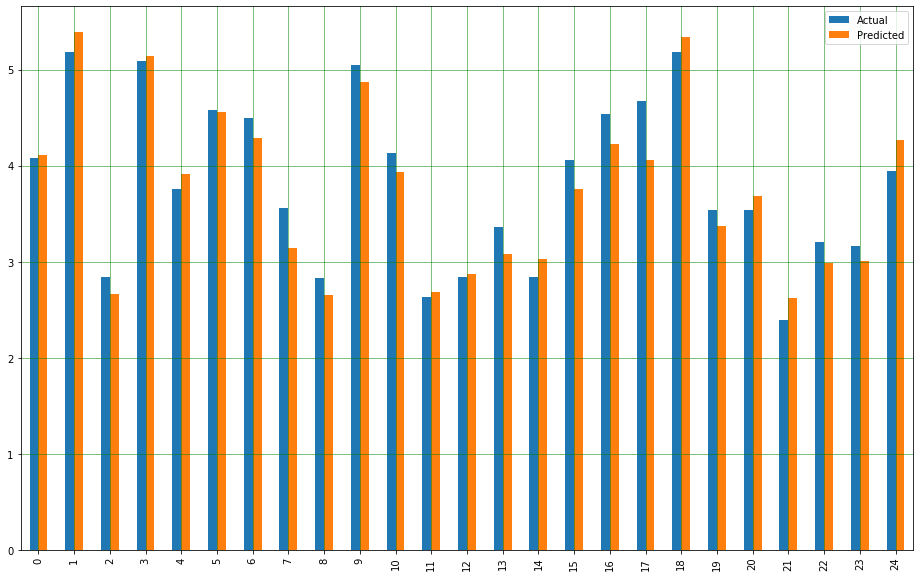

In [243]:
df_pred.head(25).plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

# Model Evaluation Metrics for Regression

In [244]:
print('Score:', lin_reg.score(X_test, y_test))

scores = cross_val_score(lin_model, X, y, cv=6)
print('Cross-validated scores:', scores)

Score: 0.864419211019473
Cross-validated scores: [0.83215756 0.83377712 0.8329685  0.83054348 0.81137819 0.80839303]


In [245]:
# Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors:
# Lower values of RMSE indicate better fit
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# Root Mean Squared Error: 0.2688327673161547

Root Mean Squared Error: 0.2688327673161547


# Use on Test Data

In [246]:
test_pred = lin_reg.predict(np.array(test_dropped))

In [247]:
final_pred = pd.DataFrame({'price_in_eur': np.exp(test_dropped['price_in_eur']), 'Predicted': np.exp(test_pred)})
final_pred

,price_in_eur,Predicted
0,24.811657,21.590752
1,35.968663,29.245609
2,36.016015,29.831053
3,36.016015,29.761718
4,35.973793,30.039275
...,...,...
5578,43.830000,50.299740
5579,51.990000,60.181954
5580,51.990000,62.219731
5581,51.990000,66.955552
